In [1]:
import torch
import matplotlib.pyplot as plt

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set("".join(words))))
stoi  = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos  = {i:s for s,i in stoi.items()}

In [2]:
# creating sample inputs and preds from raw data
context_window = 3

X, Y = [], []
for word in words[:5]:
    context = [0] * context_window
    for char in word + '.':
        itos_context= [itos[i] for i in context]
        stoi_char = stoi[char]
        X.append(context)
        Y.append(stoi_char)
        # print(f"for context {''.join(itos_context)} ===> {char}")
        context = context[1:] + [stoi[char]]
        # print(char)
        
X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"shape for input: {X.shape} ===> Targe shape {Y.shape}")

shape for input: torch.Size([32, 3]) ===> Targe shape torch.Size([32])


In [3]:
## creating the embedding matrix. think of representing each letter with 2 values instead of 1 like one hot. here 2 is embedding size
embedding_size = 2
C = torch.randn((len(stoi), embedding_size))
C.shape

torch.Size([27, 2])

In [4]:
# multiple the input with the embedding matrix. effectively we are seeing input integet representing char in each input and querying for its embedding value.
# for 32 examples, with 3 chars/words each, and each char/words represented by 2 values, we get (32, 3, 2)

C[X].shape

torch.Size([32, 3, 2])

In [5]:
emb = C[X]

# we can stack each of the 3 char/words together. we can also flatten its embedding into a 1d vector. 
# so we are getting 3 1d vectors of length 2 and concating them into single vector giving us (32, 6)

emb = emb.view(-1, context_window * embedding_size)
emb.shape

torch.Size([32, 6])

In [6]:
# manually creating the weights and biases for the model [3 words each being represented by 2 values * 1 layer of 100 neurons * 1 output layer of 27 classes]

g = torch.Generator().manual_seed(2147483647)
embedding_size = 2
C = torch.randn((len(stoi), embedding_size))
W1 = torch.randn((embedding_size * context_window, 100), generator=g)
B1 = torch.randn((100), generator=g)
W2 = torch.randn((100, len(stoi)), generator=g)
B2 = torch.randn((len(stoi)), generator=g)
parameters  = [C, W1, B1, W2, B2]

In [7]:
emb = C[X]
h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
logits = h @ W2 + B2
logits.shape

torch.Size([32, 27])

In [8]:
emb = C[X]
h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
logits = h @ W2 + B2
counts = logits.exp()
probs = counts / counts.sum(-1, keepdim=True)
probs.shape

torch.Size([32, 27])

In [9]:
probs[torch.arange(len(Y)), Y].shape

torch.Size([32])

In [10]:
# this is indexing into the probability of each predicted for the correct class.
# torch.range(1, len(Y)).long() this gives us a list from 1 to len(input) and Y gives us the correct class in form of integer for each input
# using the combination of above we can index into what the probabilities are for the correct class for each input in our models output
print("probs for 32 inputs at correct prediction ")
probs[torch.arange(len(Y)), Y]

probs for 32 inputs at correct prediction 


tensor([2.0135e-06, 2.8788e-07, 6.5296e-09, 5.3923e-05, 6.2565e-08, 7.2092e-08,
        3.0860e-04, 6.2050e-06, 2.4637e-06, 1.6430e-03, 2.5256e-06, 2.4847e-08,
        3.3635e-02, 1.4731e-02, 1.8440e-07, 1.8348e-04, 3.0594e-10, 1.6484e-05,
        3.9167e-04, 5.7936e-08, 6.9095e-10, 9.4348e-05, 4.4095e-04, 2.0436e-02,
        1.2171e-05, 2.6807e-09, 3.2540e-06, 1.5140e-06, 4.1098e-08, 1.7922e-12,
        4.6126e-10, 1.4308e-07])

In [11]:
# loss for first 32 examples
loss= -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(13.4129)

In [12]:
# calculating the loss using F.cross_entropy which should be same as above manually calculated loss.

emb = C[X]
h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
logits = h @ W2 + B2
loss= torch.nn.functional.cross_entropy(logits, Y)
loss

tensor(13.4129)

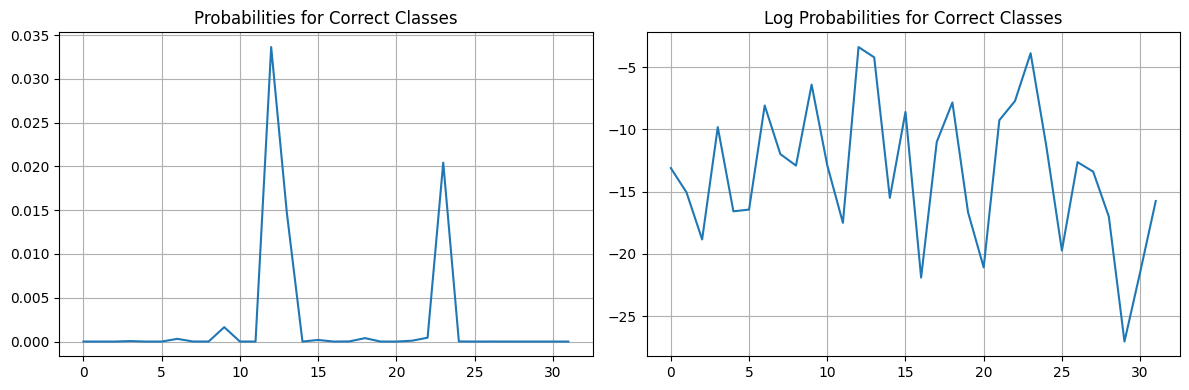

In [13]:
# plotting probs and their logs. for a trained model these should be close to 1.

plt.figure(figsize=(12, 4))

# Get probabilities and logs
correct_probs = probs[torch.arange(len(Y)), Y]
log_probs = correct_probs.log()

# Plot side by side
plt.subplot(1,2,1)
plt.plot(correct_probs.detach())
plt.title('Probabilities for Correct Classes')
plt.grid(True)

plt.subplot(1,2,2) 
plt.plot(log_probs.detach())
plt.title('Log Probabilities for Correct Classes')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# defining the dataset
print(f"{X.shape} ===> {Y.shape}")

torch.Size([32, 3]) ===> torch.Size([32])


In [15]:
# defining the model

g = torch.Generator().manual_seed(2147483647)
embedding_size = 2
C = torch.randn((len(stoi), embedding_size))
W1 = torch.randn((embedding_size * context_window, 100), generator=g)
B1 = torch.randn((100), generator=g)
W2 = torch.randn((100, len(stoi)), generator=g)
B2 = torch.randn((len(stoi)), generator=g)
parameters  = [C, W1, B1, W2, B2]
for p in parameters:
  p.requires_grad = True

print(f"total parameters: {sum(p.nelement() for p in parameters)}")

total parameters: 3481


In [16]:
# training the model only one batch of input examples and overfit by reducing loss.

for i in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
    logits = h @ W2 + B2
    loss= torch.nn.functional.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights to reduce loss
    with torch.no_grad():
        for p in parameters:
            p.data += -p.grad * 0.1
    
    print(f"loss: {loss.item()}")

loss: 16.114572525024414
loss: 13.038213729858398
loss: 10.973484992980957
loss: 9.20019245147705
loss: 7.789297103881836
loss: 6.654717445373535
loss: 5.68873405456543
loss: 4.8080830574035645
loss: 4.015576362609863
loss: 3.4188385009765625


In [63]:
# build the dataset
context_window = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * context_window
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# defining the model
g = torch.Generator().manual_seed(2147483647)
embedding_size = 2
C = torch.randn((len(stoi), embedding_size))
W1 = torch.randn((embedding_size * context_window, 100), generator=g)
B1 = torch.randn((100), generator=g)
W2 = torch.randn((100, len(stoi)), generator=g)
B2 = torch.randn((len(stoi)), generator=g)
parameters  = [C, W1, B1, W2, B2]
for p in parameters:
  p.requires_grad = True

print(f"total parameters: {sum(p.nelement() for p in parameters)}")

torch.Size([182661, 3]) torch.Size([182661])
torch.Size([22763, 3]) torch.Size([22763])
torch.Size([22722, 3]) torch.Size([22722])
total parameters: 3481


In [64]:
# instead of trying random lr we can try over a range. 
# when we plot lr and loss for this range we want to see drop in loss and eventually see loss increase so we know we have overshot lr.
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [65]:
# training the model on mini batches/

lri = []
lossi = []
stepi = []

for i in range(200000):
    mini_batch_index = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[mini_batch_index]]
    h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
    logits = h @ W2 + B2
    loss= torch.nn.functional.cross_entropy(logits, Ytr[mini_batch_index])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights to reduce loss
    # lr= lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p.data += -p.grad * lr
            
    # tracking stats:
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.item())
    
    # print(f"loss: {loss.item()}")

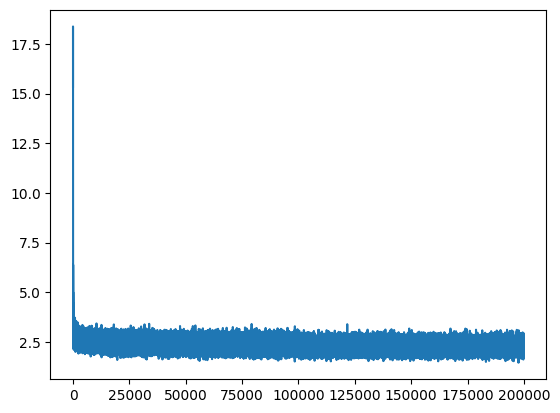

In [66]:
plt.plot(stepi, lossi)

In [67]:
# loss on dev set

emb = C[Xdev]
h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
logits = h @ W2 + B2
loss= torch.nn.functional.cross_entropy(logits, Ydev)
loss

tensor(2.2509, grad_fn=<NllLossBackward0>)

In [68]:
# loss on test set

emb = C[Xte]
h = torch.tanh(emb.view(-1, context_window * embedding_size) @ W1 + B1)
logits = h @ W2 + B2
loss= torch.nn.functional.cross_entropy(logits, Yte)
loss

tensor(2.2586, grad_fn=<NllLossBackward0>)

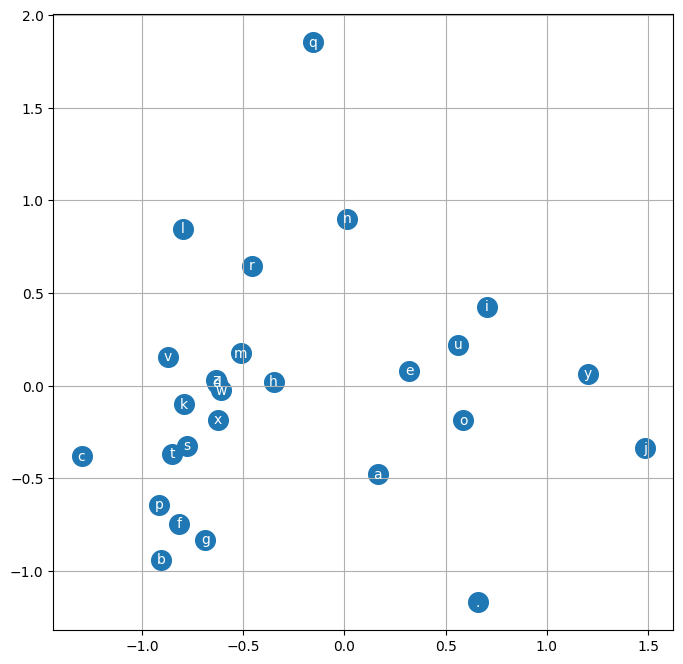

In [69]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')